In [3]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.
C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\envs\Huber\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\envs\Huber\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\envs\Huber\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 =

In [20]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                    optimizer=optimizer,
                                    metrics=['accuracy'])

        # Build the generator
        self.generator = self.generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()
        
        print('The shape of input is:',X_train.shape)
        print('The shape of image is:',X_train[0].shape)
        plt.imshow(X_train[0], cmap='gray')
        
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.show()
        fig.savefig("images/%d.png" % epoch)
        plt.close()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\envs\Huber\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.604355, acc.: 75.00%] [G loss: 0.887887]


C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\envs\Huber\lib\site-packages\ipykernel_launcher.py:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\envs\Huber\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.304875, acc.: 90.62%] [G loss: 1.026048]
2 [D loss: 0.233837, acc.: 95.31%] [G loss: 1.164382]
3 [D loss: 0.206257, acc.: 98.44%] [G loss: 1.268679]
4 [D loss: 0.137650, acc.: 100.00%] [G loss: 1.580477]
5 [D loss: 0.141160, acc.: 100.00%] [G loss: 1.607112]
6 [D loss: 0.134612, acc.: 100.00%] [G loss: 1.746711]
7 [D loss: 0.115251, acc.: 100.00%] [G loss: 1.982289]
8 [D loss: 0.101511, acc.: 100.00%] [G loss: 2.003405]
9 [D loss: 0.088972, acc.: 100.00%] [G loss: 2.128843]
10 [D loss: 0.070727, acc.: 100.00%] [G loss: 2.282955]
11 [D loss: 0.062680, acc.: 100.00%] [G loss: 2.307953]
12 [D loss: 0.075522, acc.: 100.00%] [G loss: 2.387425]
13 [D loss: 0.052508, acc.: 100.00%] [G loss: 2.342125]
14 [D loss: 0.057553, acc.: 100.00%] [G loss: 2.606266]
15 [D loss: 0.055084, acc.: 100.00%] [G loss: 2.488668]
16 [D loss: 0.053167, acc.: 100.00%] [G loss: 2.614165]
17 [D loss: 0.040379, acc.: 100.00%] [G loss: 2.793756]
18 [D loss: 0.035527, acc.: 100.00%] [G loss: 2.776139]
19 [

152 [D loss: 0.158482, acc.: 93.75%] [G loss: 4.927790]
153 [D loss: 0.713310, acc.: 73.44%] [G loss: 2.904322]
154 [D loss: 0.256942, acc.: 84.38%] [G loss: 3.754420]
155 [D loss: 0.076567, acc.: 96.88%] [G loss: 5.014224]
156 [D loss: 0.174882, acc.: 92.19%] [G loss: 3.535757]
157 [D loss: 0.189544, acc.: 90.62%] [G loss: 3.997175]
158 [D loss: 0.060967, acc.: 98.44%] [G loss: 4.656843]
159 [D loss: 0.188410, acc.: 96.88%] [G loss: 3.955621]
160 [D loss: 0.067929, acc.: 98.44%] [G loss: 4.228832]
161 [D loss: 0.223973, acc.: 89.06%] [G loss: 3.231294]
162 [D loss: 0.101134, acc.: 98.44%] [G loss: 4.227292]
163 [D loss: 0.253334, acc.: 92.19%] [G loss: 3.488127]
164 [D loss: 0.085499, acc.: 98.44%] [G loss: 4.086636]
165 [D loss: 0.545455, acc.: 73.44%] [G loss: 2.899199]
166 [D loss: 0.104240, acc.: 96.88%] [G loss: 3.854068]
167 [D loss: 0.189267, acc.: 93.75%] [G loss: 3.707870]
168 [D loss: 0.105997, acc.: 100.00%] [G loss: 3.534738]
169 [D loss: 0.125109, acc.: 100.00%] [G loss: 

302 [D loss: 0.729264, acc.: 46.88%] [G loss: 0.750877]
303 [D loss: 0.698556, acc.: 45.31%] [G loss: 0.737892]
304 [D loss: 0.772673, acc.: 35.94%] [G loss: 0.722089]
305 [D loss: 0.671528, acc.: 54.69%] [G loss: 0.801854]
306 [D loss: 0.647831, acc.: 57.81%] [G loss: 0.781645]
307 [D loss: 0.741034, acc.: 29.69%] [G loss: 0.733572]
308 [D loss: 0.695441, acc.: 43.75%] [G loss: 0.744729]
309 [D loss: 0.675791, acc.: 46.88%] [G loss: 0.801335]
310 [D loss: 0.701042, acc.: 50.00%] [G loss: 0.806027]
311 [D loss: 0.669896, acc.: 50.00%] [G loss: 0.823002]
312 [D loss: 0.651022, acc.: 57.81%] [G loss: 0.776177]
313 [D loss: 0.649003, acc.: 51.56%] [G loss: 0.759913]
314 [D loss: 0.685236, acc.: 48.44%] [G loss: 0.805768]
315 [D loss: 0.625833, acc.: 53.12%] [G loss: 0.822036]
316 [D loss: 0.695916, acc.: 42.19%] [G loss: 0.801754]
317 [D loss: 0.744561, acc.: 32.81%] [G loss: 0.719045]
318 [D loss: 0.664311, acc.: 45.31%] [G loss: 0.774393]
319 [D loss: 0.703620, acc.: 46.88%] [G loss: 0.

452 [D loss: 0.657287, acc.: 51.56%] [G loss: 0.703429]
453 [D loss: 0.657108, acc.: 54.69%] [G loss: 0.726210]
454 [D loss: 0.652188, acc.: 60.94%] [G loss: 0.716346]
455 [D loss: 0.646644, acc.: 60.94%] [G loss: 0.703084]
456 [D loss: 0.649867, acc.: 54.69%] [G loss: 0.722955]
457 [D loss: 0.644359, acc.: 53.12%] [G loss: 0.719944]
458 [D loss: 0.644393, acc.: 56.25%] [G loss: 0.736314]
459 [D loss: 0.647631, acc.: 57.81%] [G loss: 0.730067]
460 [D loss: 0.644692, acc.: 56.25%] [G loss: 0.735828]
461 [D loss: 0.659098, acc.: 53.12%] [G loss: 0.744106]
462 [D loss: 0.638746, acc.: 56.25%] [G loss: 0.763344]
463 [D loss: 0.640640, acc.: 62.50%] [G loss: 0.734393]
464 [D loss: 0.652120, acc.: 53.12%] [G loss: 0.741261]
465 [D loss: 0.637681, acc.: 54.69%] [G loss: 0.731546]
466 [D loss: 0.596825, acc.: 60.94%] [G loss: 0.741240]
467 [D loss: 0.654071, acc.: 62.50%] [G loss: 0.743159]
468 [D loss: 0.632772, acc.: 57.81%] [G loss: 0.749802]
469 [D loss: 0.649649, acc.: 56.25%] [G loss: 0.

600 [D loss: 0.661382, acc.: 60.94%] [G loss: 0.751451]
601 [D loss: 0.674536, acc.: 57.81%] [G loss: 0.732647]
602 [D loss: 0.659979, acc.: 57.81%] [G loss: 0.753762]
603 [D loss: 0.663564, acc.: 57.81%] [G loss: 0.772675]
604 [D loss: 0.662064, acc.: 56.25%] [G loss: 0.746561]
605 [D loss: 0.636806, acc.: 57.81%] [G loss: 0.733035]
606 [D loss: 0.650859, acc.: 57.81%] [G loss: 0.729533]
607 [D loss: 0.665511, acc.: 57.81%] [G loss: 0.739542]
608 [D loss: 0.646044, acc.: 59.38%] [G loss: 0.745544]
609 [D loss: 0.640818, acc.: 60.94%] [G loss: 0.728528]
610 [D loss: 0.647840, acc.: 64.06%] [G loss: 0.731964]
611 [D loss: 0.674078, acc.: 57.81%] [G loss: 0.767158]
612 [D loss: 0.615757, acc.: 70.31%] [G loss: 0.750253]
613 [D loss: 0.649843, acc.: 59.38%] [G loss: 0.789827]
614 [D loss: 0.667085, acc.: 56.25%] [G loss: 0.781238]
615 [D loss: 0.629004, acc.: 60.94%] [G loss: 0.773056]
616 [D loss: 0.665342, acc.: 62.50%] [G loss: 0.728473]
617 [D loss: 0.652181, acc.: 65.62%] [G loss: 0.

748 [D loss: 0.612823, acc.: 71.88%] [G loss: 0.754952]
749 [D loss: 0.631224, acc.: 70.31%] [G loss: 0.729479]
750 [D loss: 0.615870, acc.: 68.75%] [G loss: 0.766102]
751 [D loss: 0.629457, acc.: 70.31%] [G loss: 0.769915]
752 [D loss: 0.633869, acc.: 64.06%] [G loss: 0.781952]
753 [D loss: 0.632805, acc.: 65.62%] [G loss: 0.787800]
754 [D loss: 0.590908, acc.: 70.31%] [G loss: 0.812571]
755 [D loss: 0.618185, acc.: 67.19%] [G loss: 0.801587]
756 [D loss: 0.632501, acc.: 64.06%] [G loss: 0.814900]
757 [D loss: 0.634628, acc.: 57.81%] [G loss: 0.810390]
758 [D loss: 0.634443, acc.: 62.50%] [G loss: 0.814144]
759 [D loss: 0.644933, acc.: 64.06%] [G loss: 0.776303]
760 [D loss: 0.668280, acc.: 59.38%] [G loss: 0.791681]
761 [D loss: 0.649551, acc.: 57.81%] [G loss: 0.796990]
762 [D loss: 0.609113, acc.: 75.00%] [G loss: 0.787053]
763 [D loss: 0.636249, acc.: 64.06%] [G loss: 0.807029]
764 [D loss: 0.636922, acc.: 64.06%] [G loss: 0.771037]
765 [D loss: 0.672829, acc.: 56.25%] [G loss: 0.

896 [D loss: 0.575733, acc.: 81.25%] [G loss: 0.859426]
897 [D loss: 0.589715, acc.: 68.75%] [G loss: 0.856717]
898 [D loss: 0.601180, acc.: 73.44%] [G loss: 0.842577]
899 [D loss: 0.632163, acc.: 71.88%] [G loss: 0.831454]
900 [D loss: 0.614273, acc.: 65.62%] [G loss: 0.810726]
901 [D loss: 0.629592, acc.: 60.94%] [G loss: 0.841410]
902 [D loss: 0.618275, acc.: 70.31%] [G loss: 0.852952]
903 [D loss: 0.607843, acc.: 73.44%] [G loss: 0.819092]
904 [D loss: 0.621070, acc.: 62.50%] [G loss: 0.829983]
905 [D loss: 0.602225, acc.: 71.88%] [G loss: 0.812250]
906 [D loss: 0.585478, acc.: 70.31%] [G loss: 0.850966]
907 [D loss: 0.643834, acc.: 62.50%] [G loss: 0.817738]
908 [D loss: 0.605602, acc.: 70.31%] [G loss: 0.830966]
909 [D loss: 0.597327, acc.: 70.31%] [G loss: 0.851877]
910 [D loss: 0.607026, acc.: 71.88%] [G loss: 0.857152]
911 [D loss: 0.602240, acc.: 75.00%] [G loss: 0.838304]
912 [D loss: 0.603243, acc.: 73.44%] [G loss: 0.828604]
913 [D loss: 0.560900, acc.: 85.94%] [G loss: 0.

1043 [D loss: 0.533402, acc.: 81.25%] [G loss: 0.867863]
1044 [D loss: 0.615307, acc.: 75.00%] [G loss: 0.883508]
1045 [D loss: 0.630176, acc.: 70.31%] [G loss: 0.886828]
1046 [D loss: 0.634090, acc.: 65.62%] [G loss: 0.848651]
1047 [D loss: 0.589450, acc.: 71.88%] [G loss: 0.896905]
1048 [D loss: 0.596544, acc.: 73.44%] [G loss: 0.978624]
1049 [D loss: 0.609046, acc.: 76.56%] [G loss: 0.885562]
1050 [D loss: 0.575073, acc.: 78.12%] [G loss: 0.896011]
1051 [D loss: 0.607381, acc.: 78.12%] [G loss: 0.880600]
1052 [D loss: 0.602677, acc.: 78.12%] [G loss: 0.877144]
1053 [D loss: 0.575834, acc.: 82.81%] [G loss: 0.813057]
1054 [D loss: 0.562738, acc.: 84.38%] [G loss: 0.865314]
1055 [D loss: 0.610429, acc.: 76.56%] [G loss: 0.889814]
1056 [D loss: 0.570774, acc.: 73.44%] [G loss: 0.910665]
1057 [D loss: 0.580018, acc.: 73.44%] [G loss: 0.916853]
1058 [D loss: 0.597490, acc.: 75.00%] [G loss: 0.868531]
1059 [D loss: 0.590124, acc.: 71.88%] [G loss: 0.891223]
1060 [D loss: 0.596855, acc.: 7

1190 [D loss: 0.606344, acc.: 70.31%] [G loss: 0.923671]
1191 [D loss: 0.575041, acc.: 75.00%] [G loss: 0.905266]
1192 [D loss: 0.587065, acc.: 76.56%] [G loss: 0.874405]
1193 [D loss: 0.545486, acc.: 76.56%] [G loss: 0.865790]
1194 [D loss: 0.562548, acc.: 78.12%] [G loss: 0.846280]
1195 [D loss: 0.586686, acc.: 71.88%] [G loss: 0.939962]
1196 [D loss: 0.636854, acc.: 65.62%] [G loss: 0.927989]
1197 [D loss: 0.602915, acc.: 68.75%] [G loss: 0.848031]
1198 [D loss: 0.617540, acc.: 71.88%] [G loss: 0.869676]
1199 [D loss: 0.643670, acc.: 64.06%] [G loss: 0.886255]
1200 [D loss: 0.571947, acc.: 76.56%] [G loss: 0.858702]
1201 [D loss: 0.577441, acc.: 79.69%] [G loss: 0.844701]
1202 [D loss: 0.587471, acc.: 70.31%] [G loss: 0.896287]
1203 [D loss: 0.614216, acc.: 67.19%] [G loss: 0.854489]
1204 [D loss: 0.655696, acc.: 57.81%] [G loss: 0.891528]
1205 [D loss: 0.563457, acc.: 76.56%] [G loss: 0.954401]
1206 [D loss: 0.600267, acc.: 67.19%] [G loss: 0.873351]
1207 [D loss: 0.614118, acc.: 6

1335 [D loss: 0.544766, acc.: 75.00%] [G loss: 0.858826]
1336 [D loss: 0.554561, acc.: 73.44%] [G loss: 0.857268]
1337 [D loss: 0.605954, acc.: 68.75%] [G loss: 0.904443]
1338 [D loss: 0.513795, acc.: 82.81%] [G loss: 0.977086]
1339 [D loss: 0.609055, acc.: 70.31%] [G loss: 0.945028]
1340 [D loss: 0.552506, acc.: 71.88%] [G loss: 0.978092]
1341 [D loss: 0.570330, acc.: 78.12%] [G loss: 0.911319]
1342 [D loss: 0.558586, acc.: 73.44%] [G loss: 0.953460]
1343 [D loss: 0.612345, acc.: 68.75%] [G loss: 0.915136]
1344 [D loss: 0.594623, acc.: 70.31%] [G loss: 0.983860]
1345 [D loss: 0.572014, acc.: 75.00%] [G loss: 0.859657]
1346 [D loss: 0.565935, acc.: 79.69%] [G loss: 0.978131]
1347 [D loss: 0.552474, acc.: 84.38%] [G loss: 0.866435]
1348 [D loss: 0.589500, acc.: 79.69%] [G loss: 0.903364]
1349 [D loss: 0.567855, acc.: 76.56%] [G loss: 0.917862]
1350 [D loss: 0.597927, acc.: 67.19%] [G loss: 0.920747]
1351 [D loss: 0.551589, acc.: 78.12%] [G loss: 0.945583]
1352 [D loss: 0.553177, acc.: 7

1479 [D loss: 0.551558, acc.: 76.56%] [G loss: 0.940816]
1480 [D loss: 0.602789, acc.: 68.75%] [G loss: 1.055015]
1481 [D loss: 0.563152, acc.: 73.44%] [G loss: 1.050992]
1482 [D loss: 0.567038, acc.: 79.69%] [G loss: 0.985996]
1483 [D loss: 0.581275, acc.: 71.88%] [G loss: 0.984106]
1484 [D loss: 0.586942, acc.: 75.00%] [G loss: 0.947874]
1485 [D loss: 0.561542, acc.: 75.00%] [G loss: 0.967277]
1486 [D loss: 0.588952, acc.: 73.44%] [G loss: 0.958453]
1487 [D loss: 0.562437, acc.: 68.75%] [G loss: 0.956795]
1488 [D loss: 0.561216, acc.: 78.12%] [G loss: 0.971437]
1489 [D loss: 0.551929, acc.: 76.56%] [G loss: 1.056683]
1490 [D loss: 0.586185, acc.: 64.06%] [G loss: 1.025035]
1491 [D loss: 0.589737, acc.: 67.19%] [G loss: 1.089885]
1492 [D loss: 0.550081, acc.: 75.00%] [G loss: 0.996794]
1493 [D loss: 0.531013, acc.: 79.69%] [G loss: 0.990680]
1494 [D loss: 0.594292, acc.: 68.75%] [G loss: 0.975125]
1495 [D loss: 0.609395, acc.: 65.62%] [G loss: 0.992785]
1496 [D loss: 0.583545, acc.: 6

1626 [D loss: 0.591902, acc.: 62.50%] [G loss: 0.992187]
1627 [D loss: 0.607487, acc.: 67.19%] [G loss: 0.902123]
1628 [D loss: 0.603732, acc.: 71.88%] [G loss: 0.893150]
1629 [D loss: 0.639702, acc.: 65.62%] [G loss: 0.927787]
1630 [D loss: 0.591302, acc.: 70.31%] [G loss: 0.969623]
1631 [D loss: 0.563718, acc.: 84.38%] [G loss: 0.848459]
1632 [D loss: 0.637053, acc.: 62.50%] [G loss: 0.900678]
1633 [D loss: 0.579904, acc.: 70.31%] [G loss: 0.890543]
1634 [D loss: 0.639051, acc.: 62.50%] [G loss: 0.976864]
1635 [D loss: 0.638379, acc.: 56.25%] [G loss: 0.903891]
1636 [D loss: 0.608658, acc.: 60.94%] [G loss: 0.939068]
1637 [D loss: 0.588955, acc.: 76.56%] [G loss: 0.977407]
1638 [D loss: 0.562483, acc.: 79.69%] [G loss: 0.974290]
1639 [D loss: 0.537820, acc.: 70.31%] [G loss: 1.011745]
1640 [D loss: 0.525245, acc.: 78.12%] [G loss: 0.929153]
1641 [D loss: 0.618551, acc.: 67.19%] [G loss: 0.983297]
1642 [D loss: 0.560727, acc.: 79.69%] [G loss: 0.961790]
1643 [D loss: 0.586281, acc.: 6

1771 [D loss: 0.557884, acc.: 70.31%] [G loss: 0.991418]
1772 [D loss: 0.568233, acc.: 73.44%] [G loss: 0.998775]
1773 [D loss: 0.549352, acc.: 75.00%] [G loss: 1.000208]
1774 [D loss: 0.595664, acc.: 64.06%] [G loss: 0.977616]
1775 [D loss: 0.551456, acc.: 82.81%] [G loss: 0.916379]
1776 [D loss: 0.550941, acc.: 71.88%] [G loss: 1.025513]
1777 [D loss: 0.562603, acc.: 79.69%] [G loss: 1.013260]
1778 [D loss: 0.500493, acc.: 85.94%] [G loss: 0.976858]
1779 [D loss: 0.530908, acc.: 76.56%] [G loss: 1.059787]
1780 [D loss: 0.540470, acc.: 71.88%] [G loss: 1.099471]
1781 [D loss: 0.636773, acc.: 60.94%] [G loss: 0.968457]
1782 [D loss: 0.607255, acc.: 65.62%] [G loss: 0.934516]
1783 [D loss: 0.538161, acc.: 78.12%] [G loss: 0.890167]
1784 [D loss: 0.527920, acc.: 76.56%] [G loss: 0.954395]
1785 [D loss: 0.571010, acc.: 70.31%] [G loss: 1.038659]
1786 [D loss: 0.643720, acc.: 68.75%] [G loss: 1.081825]
1787 [D loss: 0.598479, acc.: 67.19%] [G loss: 0.992171]
1788 [D loss: 0.547508, acc.: 7

1915 [D loss: 0.651792, acc.: 62.50%] [G loss: 0.912753]
1916 [D loss: 0.552897, acc.: 68.75%] [G loss: 0.899102]
1917 [D loss: 0.526605, acc.: 82.81%] [G loss: 0.929860]
1918 [D loss: 0.637003, acc.: 60.94%] [G loss: 0.876256]
1919 [D loss: 0.588693, acc.: 68.75%] [G loss: 0.966456]
1920 [D loss: 0.565618, acc.: 68.75%] [G loss: 0.995472]
1921 [D loss: 0.581453, acc.: 71.88%] [G loss: 0.968844]
1922 [D loss: 0.590155, acc.: 68.75%] [G loss: 0.950567]
1923 [D loss: 0.553632, acc.: 76.56%] [G loss: 0.961454]
1924 [D loss: 0.574297, acc.: 67.19%] [G loss: 0.979249]
1925 [D loss: 0.607689, acc.: 64.06%] [G loss: 0.959826]
1926 [D loss: 0.573470, acc.: 73.44%] [G loss: 0.917557]
1927 [D loss: 0.603241, acc.: 68.75%] [G loss: 0.930141]
1928 [D loss: 0.568319, acc.: 67.19%] [G loss: 0.958533]
1929 [D loss: 0.659379, acc.: 60.94%] [G loss: 0.985682]
1930 [D loss: 0.581258, acc.: 70.31%] [G loss: 0.955161]
1931 [D loss: 0.608677, acc.: 62.50%] [G loss: 1.005056]
1932 [D loss: 0.533919, acc.: 7

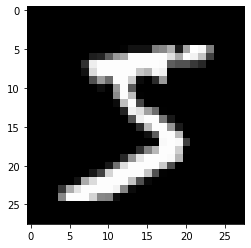

In [21]:
gan = GAN()
gan.train(epochs=2000, batch_size=32, sample_interval=200)